### Step 1:

Working with windows from the entire image. The goal of this step is to segment the image and find the features of the image i.e. vacancies, adsorbed molecules. This is done by extracting the latent vectors from the bottleneck of an autoencoder for each window, clustering the latent vectors and reconstructing a cluster map with pixelwise clustering.

Based on this pixelwise clustering, a feature detector finds the features of the clustered image, stores their (y,x) position in the image. The convention for coordinates is (y,x) because image sizes are usually given in (height, width).

Then, we cut out windows of size (32,32) pixels around the position of the feature. These so called feature windows or `step2_windows` are then used in step 2.

### Step 2

Only working with feature windows extracted in step 1. The goal of this step is to cluster the feature windows i.e. classify the features into different classes using an unsupervised algorithm. This is done by retraining the autoencoder on the feature windows dataset to make it more tailored to extract features. The latent vectors are then clustered using a spectral clustering model. The result is an array of numbers, each number being a label.

Then we circle the features on the original image, each circle having a different colour, depending on the label of the feature.

In [ ]:
# Define path where to find the module. This allows for a different path depending on where the code is running (my mac or the cluster)
import os
import sys

# Define candidate paths
module_path_list = [
    '/Users/steven/academic-iCloud/Python/modules',
    '/hpc/aklicka/Python/modules'
]

data_path_list = [
    '/Users/steven/Python-data',
    '/hpc/aklicka/Python-data/training-set-1'
    
]

# Resolve actual paths
module_path = next((p for p in module_path_list if os.path.exists(p)), None)
data_path = next((p for p in data_path_list if os.path.exists(p)), None)

# Check and report missing paths
if module_path is None:
    print("Error: Could not locate a valid module path.")
if data_path is None:
    print("Error: Could not locate a valid data path.")

if module_path is None or data_path is None:
    sys.exit(1)

# Print resolved paths
print(f"module_path = {module_path}")
print(f"data_path = {data_path}")

# Reduce TensorFlow verbosity
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


module_path = /hpc/aklicka/Python/modules
data_path = /hpc/aklicka/Python-data/training-set-1


In [2]:
# # Ensure modules are reloaded 
%load_ext autoreload
%autoreload 2

# Import standard modules
import numpy as np

import platform

from datetime import datetime

# Add custom module path to list
sys.path.append(module_path)

# Import custom module
import SRSML24.data_prep as dp
import SRSML24.model as m
import SRSML24.utils as ut

import tensorflow as tf
#from tensorflow.keras.optimizers.legacy import Adam 
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import pandas as pd
from IPython.display import display, Markdown

import skimage as ski
import skimage.morphology as morphology
import skimage
from skimage import morphology, measure

#import platform 

m.print_system_info()

start_time = dp.current_datetime()


Python version: 3.9.21 (main, Dec 11 2024, 16:24:11) 
[GCC 11.2.0]
TensorFlow version: 2.4.1
TensorFlow is built with CUDA: True
TensorFlow is built with ROCm: False

System: Linux 4.18.0-553.22.1.el8_10.x86_64 (x86_64)
Platform: Linux-4.18.0-553.22.1.el8_10.x86_64-x86_64-with-glibc2.28
Processor: x86_64

Number of GPUs available to TensorFlow: 1
GPU Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

>>> Running with GPU available <<<  (Linux-4.18.0-553.22.1.el8_10.x86_64-x86_64-with-glibc2.28)

Current time 2025-06-25 12:06:04


In [11]:
# Parameters for windows creation
# General
job_name = 'June_25_BIG_model'
verbose = False             # Set this True to print out more information

# MTRX preprocessing
flatten_method = 'poly_xy'
pixel_density = 15.0        # Convert all images to a constant pixel density
pixel_ratio = 0.7           # If an image has less than this % in the slow scan direction it is discarded
data_scaling = 1.e9         # Scale the z-height of the data

# Windowing
window_size = 32            # Window size for training/validation
window_pitch = 8            # Window pitch for training/validation

# Data saving options
save_windows = True         # Save the windows as numpy files
together = True             # Set this True to save image windows for a mtrx image as a single file rather than separate files.
save_jpg = False            # Save the full image as a jpg
collate = False             # Set this True to remove all subfolder directories and save all data in root data path
save_window_jpgs = False    # Save the windows as jpgs for inspection

# Parameters for training
model_name = 'unet_' + job_name
batch_size = 128
buffer_size = 12800 # shuffling
learning_rate = 1e-4
epochs = 5

# Parameters for clustering
cluster_model_name = model_name + '_kmeans'
cluster_batch_size = 5120 # This is the number of latent features in a batch for clustering. 
                          # Does not have to be the same as for training and probably should 
                          # be larger. 
cluster_buffer_size = cluster_batch_size * 5    # shuffling buffer
num_clusters=20                                 # Desired number of clusters (centroids) to form in the data.
max_iter=1000                                   # Maximum iterations allowed for each mini-batch to refine centroids.
reassignment_ratio=0.05                         # Fraction of clusters reassigned per step; lower values stabilize updates.

# Parameters for PREDICTIONS
predict_window_pitch = 2                        # Window pitch for prediction
predictions_batch_size = 2**15                  # Batch size for predictions


# DATA LIMITS FOR TESTING THE CODE
mtrx_train_data_limit = None                    # Number of MTRX files to process (training)
mtrx_test_data_limit = None                     # Number of MTRX files to process (validation)

train_data_limit = None                           # Limit the data used in the autoencoder training
test_data_limit = None                          # Limit the data used in the autoencoder training (validation)

# Step 2
cluster_model_spectral_name = model_name + "_spectral"

max_size_blob = 3000 #maximum pixel area of a blob to keep in the image
area_threshold = 50 #minimum pixel area of a blob to keep in the image
feature_size = 16 #radius of feature window taken from the centroid of the blob, actual window size is 2*feature_size

In [4]:

job_data_path = dp.create_new_data_path(data_path, job_name, include_date=False)

mtrx_train_path = os.path.join(data_path, 'mtrx/train')
mtrx_test_path = os.path.join(data_path, 'mtrx/test')
mtrx_predict_path = os.path.join(data_path, 'mtrx/predict')

# Step 1 paths
model_path = os.path.join(job_data_path,'model')
cluster_model_path = os.path.join(job_data_path,'cluster_model')

latent_features_path = os.path.join(job_data_path, 'latent_features')
predict_latent_features_path = os.path.join(job_data_path, 'latent_features_predictions')

windows_train_path = os.path.join(job_data_path, 'windows/train')
windows_test_path = os.path.join(job_data_path, 'windows/test')
windows_predict_path = os.path.join(job_data_path, 'windows/predict')

predictions_path = os.path.join(job_data_path, f'predictions')

# Step 2 paths
step2_model_path = os.path.join(job_data_path,'step2/model')
step2_cluster_model_path = os.path.join(job_data_path,'step2/cluster_model')

step2_latent_features_train_path = os.path.join(job_data_path, 'step2/latent_features/train')
step2_latent_features_test_path = os.path.join(job_data_path, 'step2/latent_features/test')
step2_latent_features_predict_path = os.path.join(job_data_path, 'step2/latent_features/predict')


step2_predict_latent_features_path = os.path.join(job_data_path, 'step2/latent_features_predictions')


step2_windows_train_path = os.path.join(job_data_path, 'step2/windows/train')
step2_windows_test_path = os.path.join(job_data_path, 'step2/windows/test')
step2_windows_predict_path = os.path.join(job_data_path, 'step2/windows/predict')

step2_predictions_path = os.path.join(job_data_path, f'step2/predictions')



### Process Matrix format data to windows for making predictions 


In [ ]:
dp.delete_data_folders(
    job_data_path, 
    subdirectories=['windows/predict','windows-jpg/predict','jpg/predict'],
    override=True)

In [ ]:
# Prediction data in MTRX format
mtrx_predict_file_list, _ = dp.list_files_by_extension(mtrx_predict_path,'Z_mtrx',verbose=False)

dp.process_mtrx_files(
    mtrx_predict_file_list,
    job_data_path, # save data path
    flatten_method = flatten_method, pixel_density = pixel_density, pixel_ratio = pixel_ratio,
    data_scaling = data_scaling, window_size = window_size, 
    window_pitch = predict_window_pitch,
    save_windows = save_windows,
    save_window_jpgs=save_window_jpgs,
    save_jpg = save_jpg,
    together = together,
    collate = collate,
    verbose = verbose
)

### Step 1: Making cluster image. Make predictions using the trained autoencoder and KMEANS models. Extract feature windows

In step 1, all windows are used. Latent vectors relate to windows extracted from the entire image.

In [5]:
# Load the trained autoencoder
autoencoder_model = m.load_model(model_path, model_name=model_name)

# Load a previously saved cluster model from disk
cluster_model = m.load_cluster_model(cluster_model_path, model_name=cluster_model_name)

Model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/model/unet_June_25_BIG_model.keras
Cluster model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/cluster_model/unet_June_25_BIG_model_kmeans.pkl


In [14]:
max_size_blob = 3000 #maximum pixel area of a blob to keep in the image
area_threshold = 50 #minimum pixel area of a blob to keep in the image
feature_size = 16 #radius of feature window taken from the centroid of the blob, actual window size is 2*feature_size

In [6]:
step1_predict_files, step1_num_predict = dp.list_files_by_extension(windows_predict_path, 'npy')

# Get the corresponding image coordimages list file
step1_prediction_windows_coordinates_file_list , _ = dp.list_files_by_extension(windows_predict_path,'.txt',verbose=False)
step1_prediction_windows_coordinates_file_list = [
    name for name in step1_prediction_windows_coordinates_file_list 
    if "coordinates" in name
]


Found 32 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/predict
Found 64 files with extension '.txt' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/predict


### Only run next code window if you do not have the feature windows already saved

Takes about 10 mins for 32 images

the function `extract_and_save_feature_windows` takes an optional argument `feature_extract_alg` which can take integer values (0,1, or 2). This determines which feature extraction algorithm to use. The default is 0.

0 - detects the most number of features from the cluster image out of all of the algorithms. The drawback is that it also captures a large number incorrect features and sometimes captures the same feature multiple times. This is not such a large problem because the clustering will determine what is a feature and what isn't. This is the default.

1 - Most conservative feature extraction algorithm, does not pick up all the features.

2 - Middle of the road option. But I think 0 is a better overall option.



In [ ]:
dp.delete_data_folders(job_data_path, subdirectories=["step2/windows/predict"], override=True)


# Extracting the feature windows from the prediction dataset 
m.extract_and_save_feature_windows(step1_predict_files, step1_prediction_windows_coordinates_file_list, autoencoder_model, cluster_model, 
                                 window_size=window_size, predictions_batch_size=predictions_batch_size, feature_size=feature_size, save_path=step2_windows_predict_path, verbose=True)



No target folders found to delete.
Prediction file: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/predict/default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_BD/default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_BD_all_windows.npy
Coords file: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/predict/default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_BD/default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_BD_coordinates.txt

---
Processing file default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_BD_all_windows.npy
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (32768, 32, 32, 1)


### Step 2: Cluster Feature windows. Display labeled features.

Step 2 only uses windows cut around the found features in the image. The latent vectors for step 2 are related to the 'feature' windows.

In [7]:
# Load the trained autoencoder
step2_autoencoder_model = m.load_model(step2_model_path, model_name=model_name)

# Load a previously saved cluster model from disk
step2_cluster_model_kmeans = m.load_cluster_model(step2_cluster_model_path, model_name=cluster_model_name)
step2_cluster_model_spectral = m.load_cluster_model(step2_cluster_model_path, model_name=cluster_model_spectral_name)




Model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/model/unet_June_25_BIG_model.keras
Cluster model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/cluster_model/unet_June_25_BIG_model_kmeans.pkl
Cluster model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/cluster_model/unet_June_25_BIG_model_spectral.pkl


### Displays the feature windows according to their cluster label

The function `predict_labels_from_feature_windows` takes an argument `cluster_model` and `cluster_model_type` which determine which cluster model to use. the default is "kmeans" and the other option is "spectral". To change the cluster model used, you must provide a different `cluster_model` as well as `cluster_model_type`

Found 32 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/windows/predict
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (210, 32, 32, 1)

Deleted: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/latent_features/predict
All specified folders have been successfully deleted.
Processing batch 1, input shape: [210  32  32   1]
Latent features shape for batch 1: (210, 4096)
Saved latent features for batch 1 to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/latent_features/predict/feature_windows_latent_features_predict_batch_0.npy

All latent features have been saved to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/latent_features/predict.
Sample batch shape: (210, 4096)
Found 1 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/latent_features/predict


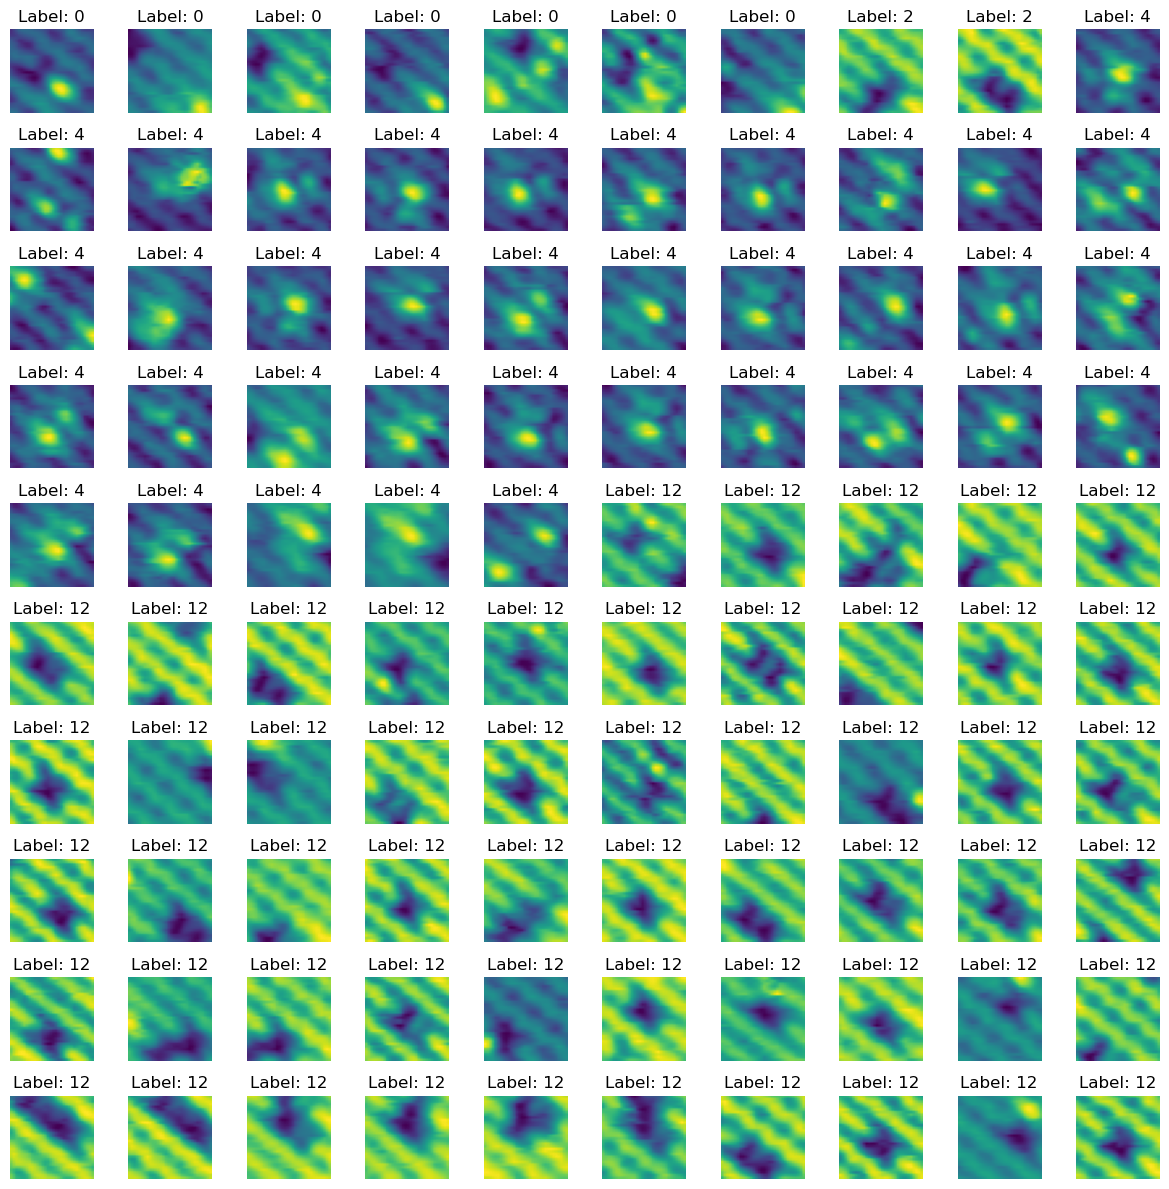

In [9]:
image_num = 2



# Step 2
windows, labels = m.predict_labels_from_feature_windows(step2_windows_predict_path, step2_latent_features_predict_path, job_data_path, step2_autoencoder_model, step2_cluster_model_kmeans, 
                                                        cluster_model_type="kmeans", image_num = image_num, feature_size = 16, predictions_batch_size=2**15)

# Sort the labels numerically, while also sorting the corresponding feature windows
sorted_indices = np.argsort(labels)
sorted_labels = labels[sorted_indices]
sorted_feature_windows = windows[sorted_indices]
m.display_feature_windows_with_labels(sorted_feature_windows, sorted_labels, num_images=min(windows.shape[0],100))



---
Processing file default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_FD_all_windows.npy
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (32768, 32, 32, 1)
......Combined latent features shape: (189225, 4096)
Found 32 files with extension '.txt' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/step2/windows/predict


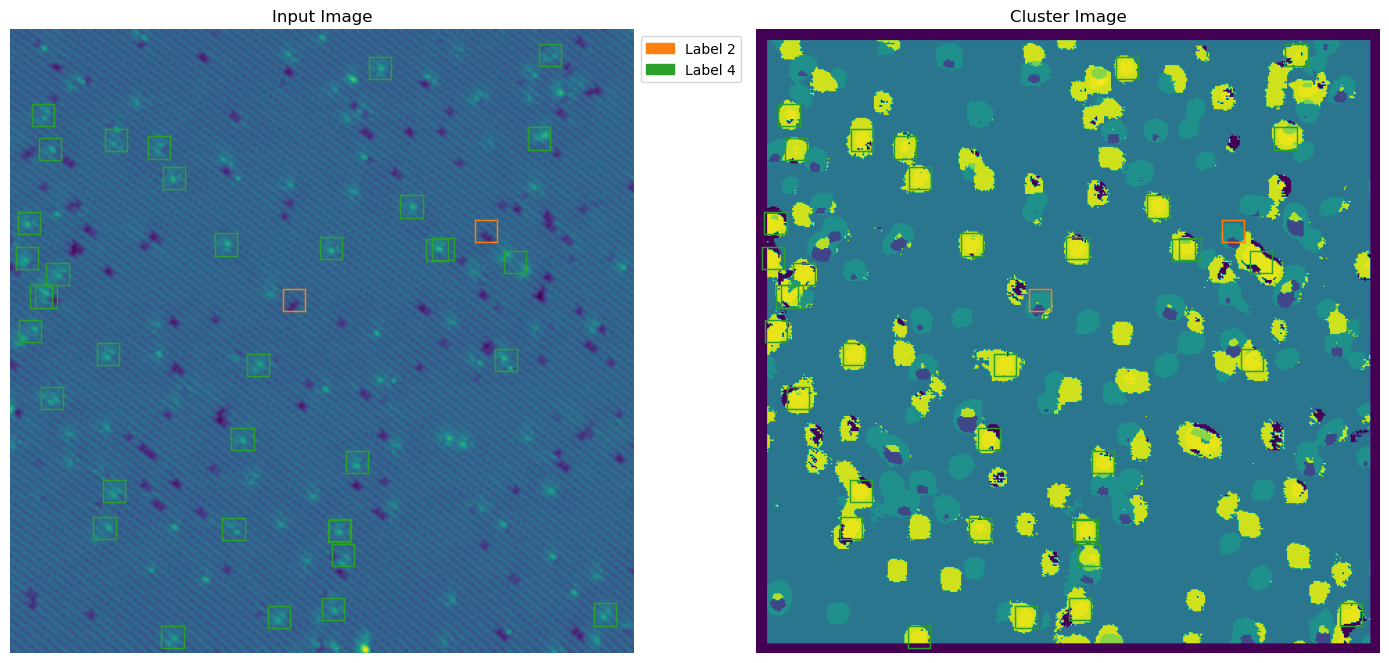

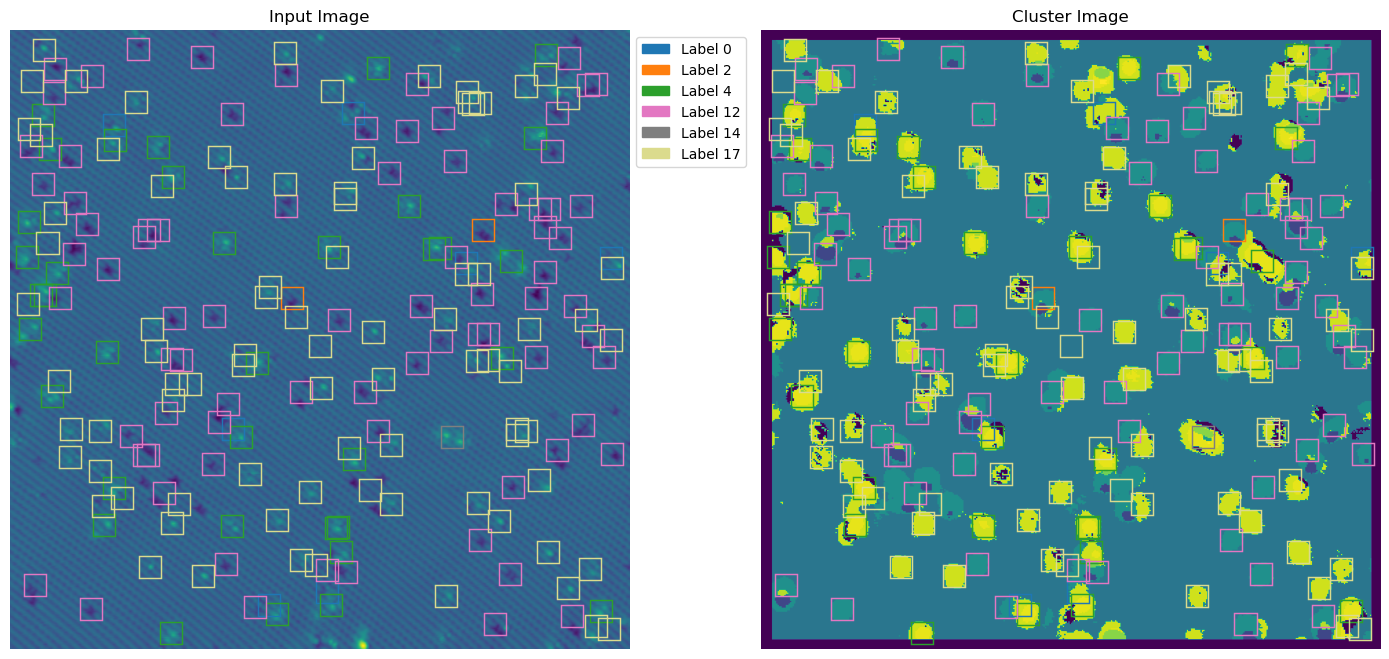

In [12]:

#get reconstructed image and cluster image
reconstructed_img, cluster_img = m.reconstruct_predict(step1_predict_files[image_num], step1_prediction_windows_coordinates_file_list[image_num], autoencoder_model, cluster_model, window_size, predictions_batch_size)

# Get the corresponding image coordimages list file
step2_prediction_windows_coordinates_file_list , _ = dp.list_files_by_extension(step2_windows_predict_path,'.txt',verbose=False)

# Get the coordinates for a specific image with index `image_num`
coordinates_data = np.loadtxt(step2_prediction_windows_coordinates_file_list[image_num], skiprows=1, dtype=float).astype(np.int64)

# Show the original image with all found features in different coloured squares
m.display_labels_on_image(reconstructed_img, coordinates_data, labels, label_num=[2,4], show_cluster_img=True, cluster_img=cluster_img)

m.display_labels_on_image(reconstructed_img, coordinates_data, labels, label_num=[], show_cluster_img=True, cluster_img=cluster_img)

#### Display reconstructed image with features circled

In [ ]:
#get reconstructed image and cluster image
reconstructed_img, cluster_img = m.reconstruct_predict(predict_files[image_num], prediction_windows_coordinates_file_list[image_num], autoencoder_model, cluster_model, window_size, predictions_batch_size)

# Get the corresponding image coordimages list file
step2_prediction_windows_coordinates_file_list , _ = dp.list_files_by_extension(step2_windows_predict_path,'.txt',verbose=False)

# Get the coordinates for a specific image with index `image_num`
coordinates_data = np.loadtxt(step2_prediction_windows_coordinates_file_list[image_num], skiprows=1, dtype=float).astype(np.int64)

In [ ]:
#import the tab10 colormap as an array
import matplotlib.patches as mpatches

colormap = [ "orange", "tab:pink", "tab:red", "tab:green", "yellow", "purple",  "tab:cyan", "tab:blue", "darkred", "blue"]
unique_labels = np.unique(labels)

patches = []
label_names = []

fig, ax = plt.subplots(figsize = (7,7))
ax.imshow(reconstructed_img, cmap="gray")

for number in unique_labels:
    indexes = [i for i, val in enumerate(labels) if val == number]
    for index in indexes:
        y, x = coordinates_data[index]
        r = plt.Rectangle((x-16, y-16),width = 32, height = 32, color = colormap[number], linewidth=1.05, fill = False)
        ax.add_patch(r)
    
    # Add a patch for the legend (only once per label)
    patch = mpatches.Patch(color=colormap[number], label=f"Label {number}")
    patches.append(patch)
    label_names.append(f"Label {number}")

ax.legend(handles=patches, labels=label_names, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()


In [ ]:
jpg_predictions_files, num_jpg_predict = dp.list_files_by_extension(predictions_path, 'jpg')
#display a jpg prediction with index jpg_predictions_files[0]
jpg_prediction_file = jpg_predictions_files[image_num]
jpg_prediction = ski.io.imread(jpg_prediction_file)
plt.figure(figsize=(20, 10))
plt.imshow(jpg_prediction, cmap='viridis')
plt.title(f'Prediction: {os.path.basename(jpg_prediction_file)}')
plt.axis('off')

In [ ]:
cluster_img.shape

In [ ]:
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt

image_gray = cluster_img.astype(float)
blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=0.1)
print("Number of blobs detected using LoG:", len(blobs_log))
# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=0.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
print("Number of blobs detected using DoG:", len(blobs_dog))

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=0.01)
print
blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(cluster_img, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
image_gray = cluster_img.astype(float)
image_gray = np.expand_dims(image_gray, axis=-1)  # Now shape is (900, 900, 1)


In [ ]:
blobs_dog = blob_log(image_gray, max_sigma=30, threshold=0.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
print("Number of blobs detected using DoG:", len(blobs_dog))

In [ ]:
print(blobs_dog)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figsize (width, height) as desired
color = 'red'  # Color for the circles
ax.set_title('Blobs Detected using DoG')
ax.imshow(cluster_img, interpolation='nearest')
for blob in blobs_dog:
    y, x, z, r = blob
    c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
    ax.add_patch(c)